### Unsupervised Analysis of Congressional Laws

In [53]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)

In [54]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import (NMF,
                                   TruncatedSVD)
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

In [55]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)
paragraph_count_df = laws_df.applymap(lambda x: str.count(x, '\n\n')).reset_index()
paragraph_count_df.rename(columns={'index':'id','text':'paragraphs'},inplace=True)

In [56]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

In [57]:
np.shape(laws_df)

(3896, 1)

__Import Law Summary Data__

In [58]:
laws_summaries = pd.read_csv('laws_summary.csv')

__ Import Custom Stop Words__

In [59]:
custom_stopwords_df = pd.read_csv('custom_stopwords_more.csv')
custom_sw = frozenset(custom_stopwords_df.iloc[:,1])

In [60]:
custom_sw

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'amended',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'ante',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'april',
           'are',
           'around',
           'as',
           'at',
           'august',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',

## NMF

In [61]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words = custom_sw, 
                                   token_pattern="\\b[a-z][a-z]{2,100}\\b",
                                   max_df = 0.90,
                                   min_df = 50)

In [62]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [63]:
dtm

<3896x16774 sparse matrix of type '<class 'numpy.float64'>'
	with 2398375 stored elements in Compressed Sparse Row format>

In [64]:
num_groups = 20
nmf_model = NMF(num_groups )
dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [65]:
np.shape(nmf_model.components_)

(20, 16774)

In [66]:
np.shape(dtm_nmf)

(3896, 20)

In [67]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: post office post facility service located postal facility united postal service states postal reference located office references office approved service office note office designation states facility facility referred designate facility designation facility street

Topic: 1
Keywords: health secretary fiscal state year program care services education fiscal year shall public health research grant programs secretary shall child health service children drug

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse note courthouse references courthouse approved courthouse referred street designate united reference designation united infrastructure congressional assembled designation comm transportation states united located act designate regulation document reference law map regulation

Topic: 3
Keywords: land secretary national park conveyance forest lands federal land bo

__Investigate whether Topics identified match title__

In [68]:
def rank_df(df,rank,num_groups):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [69]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

rank_df(nmf_df,1,num_groups)
rank_df(nmf_df,2,num_groups)
rank_df(nmf_df,3,num_groups)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

nmf_df = nmf_df.merge(laws_summaries[['id',
                                      'title',
                                      'sponsor_party',
                                      'sponsor_state',
                                      'congress','url'
                                     ]],on = 'id',how = 'left')

In [70]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
3810,c114publ49,"H.R.2559 - To designate the ""PFC Milton A. Lee Medal of Honor Memorial Highway"" in the State of ...",17,0,14
394,c105publ154,S.1575 - A bill to rename the Washington National Airport located in the District of Columbia an...,13,3,17
417,c105publ175,H.J.Res.102 - Expressing the sense of the Congress on the occasion of the 50th anniversary of th...,17,19,4
1230,c108publ185,"H.J.Res.82 - Making further continuing appropriations for the fiscal year 2004, and for other pu...",4,5,11
1229,c108publ184,H.R.3491 - National Museum of African American History and Culture Act 108th Con...,12,17,9
288,c104publ59,S.440 - National Highway System Designation Act of 1995 104th Congress (1995-1996),19,5,13
1680,c109publ141,H.R.4508 - Coast Guard Hurricane Relief Act of 2005 109th Congress (2005-2006),16,19,13
1442,c108publ376,H.R.2010 - To protect the voting rights of members of the Armed Services in elections for the De...,16,11,17
576,c105publ318,H.R.4151 - Identity Theft and Assumption Deterrence Act of 1998 105th Congress (...,19,11,9
286,c104publ57,H.R.2394 - Veterans' Compensation Cost-of-Living Adjustment Act of 1995 104th Co...,6,11,4


In [71]:
# See if Group 7 and Group are used in the same documents
nmf_df[['id','title','MAX1','MAX2','MAX3']].loc[nmf_df['MAX1']==0,:].head(n=10)

,id,title,MAX1,MAX2,MAX3
61,c104publ154,"S.1903 - A bill to designate the bridge, estimated to be completed in the year 2000, that replac...",0,14,2
99,c104publ189,"H.R.3834 - To redesignate the Dunning Post Office in Chicago, Illinois, as the ""Roger P. McAulif...",0,7,3
403,c105publ162,"S.985 - A bill to designate the post office located at 194 Ward Street in Patterson, New Jersey,...",0,17,7
491,c105publ241,S.2112 - Postal Employees Safety Enhancement Act 105th Congress (1997-1998),0,1,11
724,c105publ97,H.R.2129 - To designate the United States Post Office located at 150 North 3rd Street in Steuben...,0,2,14
726,c105publ99,H.R.2564 - To designate the United States Post Office located at 450 North Centre Street in Pott...,0,2,14
748,c106publ29,H.R.432 - To designate the North/South Center as the Dante B. Fascell North-South Center. ...,0,6,17
808,c107publ144,S.737 - A bill to designate the facility of the United States Postal Service located at 811 Sout...,0,2,15
898,c107publ225,H.R.3287 - To redesignate the facility of the United States Postal Service located at 900 Brentw...,0,14,2
949,c107publ271,H.R.4797 - To redesignate the facility of the United States Postal Service located at 265 South ...,0,17,7


Ok. Its clear that some of these groups are very similar. Especially the ones related to the post office. Lets see if we can use AgglomeraGve Clustering to find a heirarchy of groups

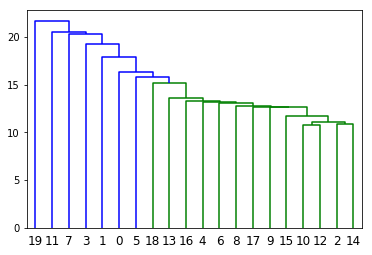

In [72]:
from scipy.cluster.hierarchy import dendrogram, linkage
data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1]]
Z = linkage(dtm_nmf.transpose())
dendrogram(Z,labels=list(range(0,np.shape(dtm_nmf)[1]))) ; 

In [73]:
nmf_df

,id,0,1,2,3,4,5,6,7,8,...,18,19,MAX1,MAX2,MAX3,title,sponsor_party,sponsor_state,congress,url
0,c104publ1,0.008007,0.000000,0.000000,0.000000,0.000000,0.237575,0.012017,0.000000,0.000000,...,0.000000,0.611855,11,19,12,S.2 - Congressional Accountability Act of 1995 104th Congress (1995-1996),R,IA,104.0,https://www.congress.gov/bill/104th-congress/senate-bill/2/text
1,c104publ10,0.003669,0.000000,0.008707,0.082134,0.000000,0.222041,0.000000,0.000000,0.014830,...,0.722368,0.085209,18,11,5,H.R.421 - To amend the Alaska Native Claims Settlement Act to provide for the purchase of common...,R,AK,104.0,https://www.congress.gov/bill/104th-congress/house-bill/421/text
2,c104publ100,0.000000,0.000000,0.032427,0.000000,0.048960,0.000000,0.000000,0.942224,0.000000,...,0.000000,0.000000,7,14,4,H.R.1606 - An Act to designate the United States Post Office building located at 24 Corliss Stre...,D,RI,104.0,https://www.congress.gov/bill/104th-congress/house-bill/1606/text
3,c104publ101,0.006407,0.000000,0.002586,0.010127,0.020827,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,14,4,3,"H.R.2061 - To designate the Federal building located at 1550 Dewey Avenue, Baker City, Oregon as...",R,OR,104.0,https://www.congress.gov/bill/104th-congress/house-bill/2061/text
4,c104publ102,0.000000,0.000000,0.000000,0.374300,0.020438,0.000000,0.000000,0.000000,0.000000,...,0.897272,0.011826,18,3,18,S.1341 - Saddleback Mountain-Arizona Settlement Act of 1995 104th Congress (1995...,R,AZ,104.0,https://www.congress.gov/bill/104th-congress/senate-bill/1341/text
5,c104publ103,0.000000,0.095490,0.026842,0.000000,0.226546,0.036858,0.004206,0.001070,0.000000,...,0.000000,0.220770,11,4,19,H.R.2924 - To guarantee the timely payment of social security benefits in March 1996. ...,R,TX,104.0,https://www.congress.gov/bill/104th-congress/house-bill/2924/text
6,c104publ104,0.040358,0.187202,0.000000,0.040768,0.000000,0.126913,0.000000,0.000000,0.000000,...,0.000000,0.206699,9,11,19,S.652 - Telecommunications Act of 1996 104th Congress (1995-1996),R,SD,104.0,https://www.congress.gov/bill/104th-congress/senate-bill/652/text
7,c104publ105,0.004089,0.015965,0.000000,0.000325,0.000000,0.372370,0.000000,0.000000,0.000000,...,0.000000,0.010588,11,5,15,H.R.2029 - Farm Credit System Reform Act of 1996 104th Congress (1995-1996),R,CO,104.0,https://www.congress.gov/bill/104th-congress/house-bill/2029/text
8,c104publ106,0.000000,0.125572,0.000000,0.099191,0.053066,0.045356,0.016870,0.001520,0.000000,...,0.025749,0.175826,16,19,16,S.1124 - National Defense Authorization Act for Fiscal Year 1996 104th Congress ...,R,SC,104.0,https://www.congress.gov/bill/104th-congress/senate-bill/1124/text
9,c104publ107,0.000000,0.000000,0.000000,0.000000,0.000000,0.961787,0.000000,0.000000,0.000000,...,0.000000,0.177481,5,16,19,"H.R.1868 - Foreign Operations, Export Financing, and Related Programs Appropriations Act, 1996 ...",R,AL,104.0,https://www.congress.gov/bill/104th-congress/house-bill/1868/text


## TSNE Visualization (NMF)

In [74]:
np.shape(dtm_nmf)

(3896, 20)

In [75]:
tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  early_exaggeration=4.0,
                  n_iter=5000,
                  verbose=2,
                  random_state = 101)

tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.066137
[t-SNE] Iteration 25: error = 1.6376219, gradient norm = 0.0017065
[t-SNE] Iteration 50: error = 1.7513493, gradient norm = 5.8911910
[t-SNE] Iteration 75: error = 1.7830914, gradient norm = 81990.9062500
[t-SNE] Iteration 75: error difference 0.000000. Finished.
[t-SNE] KL divergence after 75 iterations with early exaggeration: 1.783091
[t-SNE] Iteration 100: error = 1.7830914, gradient norm = 1249880320.0000000
[t-SNE] Iteration 100: error difference 0.000000. Finished.
[t-SNE] Error after 100 iterations: 1.783091


In [76]:
tsne_df = pd.DataFrame(tsne_nmf,columns=['tsne_x','tsne_y'])
tsne_df['robo_group'] = nmf_df['MAX1']
tsne_df['title'] = nmf_df['title']

In [77]:
tsne_df['title'] = tsne_df['title'].str.replace('\n',' ')
tsne_df['title'] = tsne_df['title'].str.replace('.','')
tsne_df['title'] = tsne_df['title'].str.replace('-','_')
tsne_df['title'] = tsne_df['title'].str.replace('[^a-zA-Z0-9\s\_]','')
tsne_df['title'] = tsne_df['title'].str.replace(' ','_')
tsne_df['title'] = tsne_df['title'].str.replace(r'(\_)\1+', r'\1')
tsne_df['title'] = tsne_df['title'].str.replace('_',' ')

In [78]:
tsne_df['paragraphs'] = np.sqrt(paragraph_count_df.paragraphs)

In [79]:
tsne_df['sponsor'] = laws_summaries['sponsor']
tsne_df['url'] = laws_summaries['url']

In [80]:
tsne_df.iloc[1000:1005,:]

,tsne_x,tsne_y,robo_group,title,paragraphs,sponsor,url
1000,-7.094929e+08,-3.832219e+08,19,HR3833 Dot Kids Implementation and Efficiency Act of 2002 107th Congress 2001 2002,6.324555,"Rep. Johnson, Sam [R-TX-3]",https://www.congress.gov/bill/106th-congress/house-bill/1509/text
1001,-3.427801e+09,8.613952e+09,19,HR5504 Antons Law 107th Congress 2001 2002,6.164414,"Rep. Norton, Eleanor Holmes [D-DC-At Large]",https://www.congress.gov/bill/106th-congress/house-bill/3201/text
1002,-1.501861e+09,-6.452174e+08,9,HR727 To amend the Consumer Product Safety Act to provide that low speed electric bicycles are c...,4.358899,"Rep. Gilman, Benjamin A. [R-NY-20]",https://www.congress.gov/bill/106th-congress/house-bill/1379/text
1003,-1.410892e+09,5.965714e+09,7,HR821 To designate the facility of the United States Postal Service located at 1030 South Church...,3.605551,"Rep. Lantos, Tom [D-CA-12]",https://www.congress.gov/bill/106th-congress/house-bill/3632/text
1004,-2.562125e+07,-3.726000e+08,3,HR2595 To direct the Secretary of the Army to convey a parcel of land to Chatham County Georgia ...,4.000000,"Rep. Bono, Mary [R-CA-44]",https://www.congress.gov/bill/106th-congress/house-bill/3676/text


In [81]:
tsne_df.to_csv('tsne_data_attemp4.csv')

Color by Topic

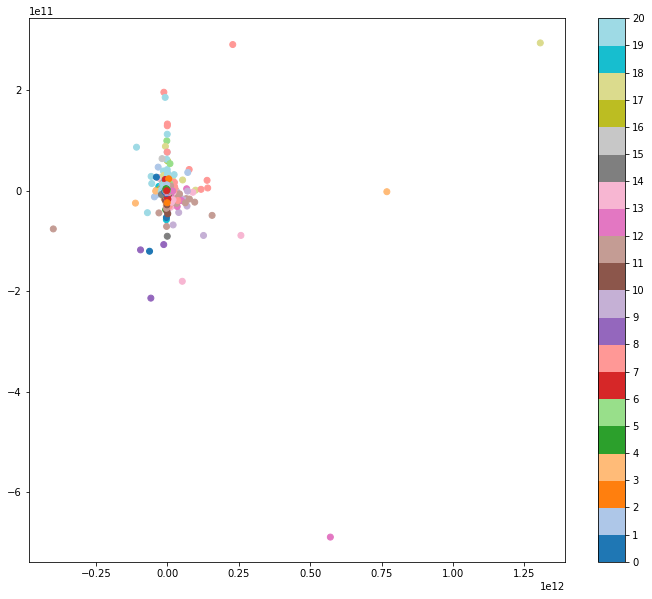

In [82]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=nmf_df.MAX1, 
            cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num_groups)
plt.show()

Color by Party

In [83]:
c_bar_party = nmf_df['sponsor_party']

m_dict = {'D':0,'R':1}
c_bar_party = c_bar_party.map(m_dict)

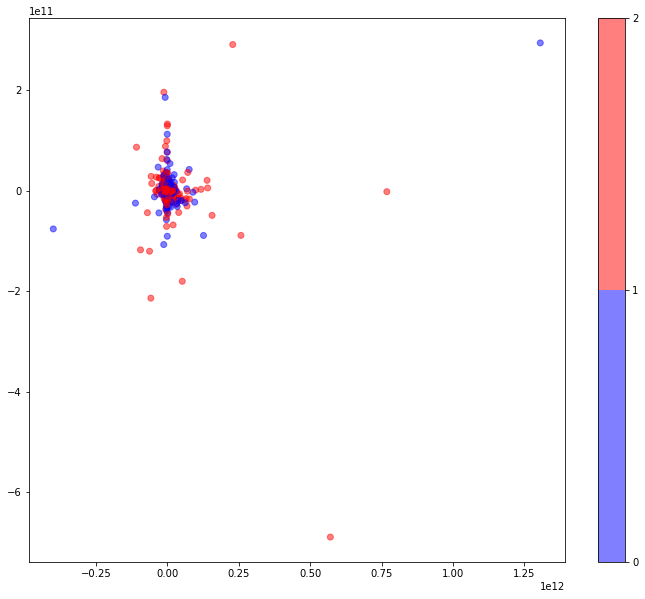

In [84]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], 
            tsne_nmf[:,1], 
            c=c_bar_party, 
            cmap=plt.cm.get_cmap("bwr", 2),
           alpha = 0.5)
plt.colorbar(ticks=range(2+1))
plt.clim(0, 2)
plt.show()

Color by state of sponsoring congress person

In [85]:
states = laws_summaries['sponsor_state'].unique()

states_dict = dict()
for ix, s in enumerate(states):
    states_dict[s] = ix
    
num_states = ix + 1

c_bar_state = nmf_df['sponsor_state']
c_bar_state = c_bar_state.map(states_dict)

states_df = pd.DataFrame(list(states_dict.items()),columns=['states','num'])

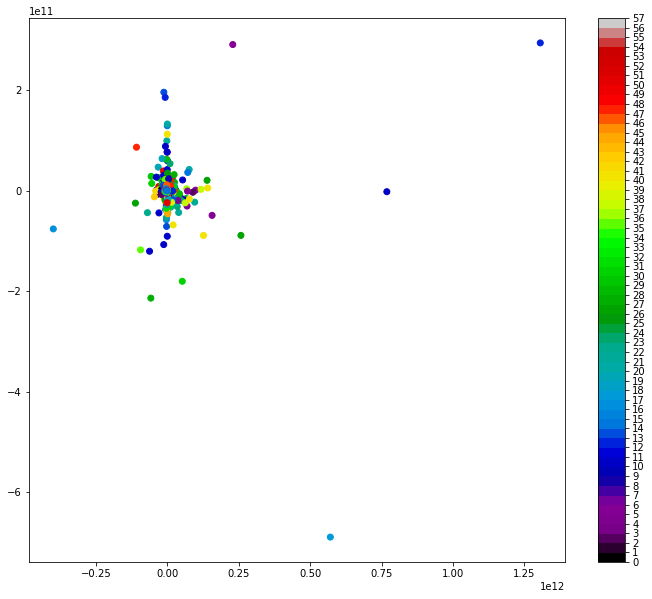

<function matplotlib.pyplot.colorbar>

In [86]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_state, 
            cmap=plt.cm.get_cmap("nipy_spectral", num_states))
plt.colorbar(ticks=range(num_states+1))
plt.clim(0, num_states)
plt.show()

plt.colorbar

Color by congressional sessions chronologically

In [87]:
congress = laws_summaries['congress'].unique()

congress_dict = dict()
for ix, c in enumerate(congress):
    congress_dict[c] = ix
    
num_congress = ix + 1

c_bar_congress = nmf_df['congress']
c_bar_congress = c_bar_congress.map(congress_dict)

congress_df = pd.DataFrame(list(congress_dict.items()),columns=['congress','num'])

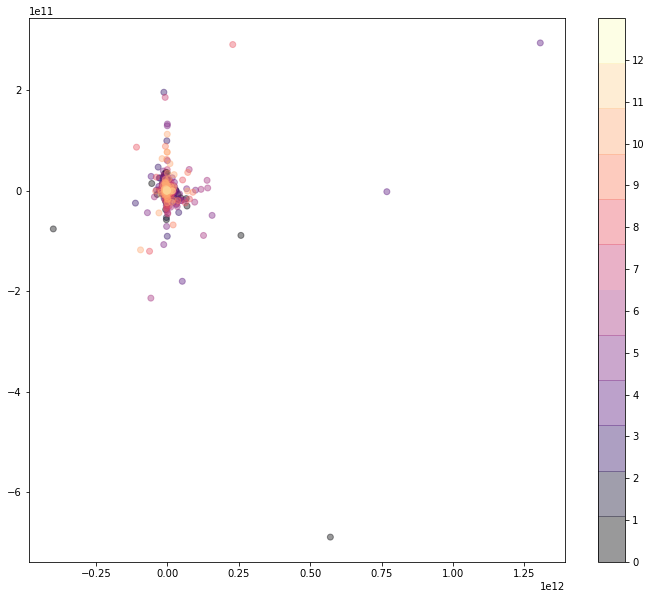

<function matplotlib.pyplot.colorbar>

In [88]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0],
            tsne_nmf[:,1], 
            c=c_bar_congress, 
            cmap=plt.cm.get_cmap("magma", num_congress),
            alpha = 0.4)
plt.colorbar(ticks=range(num_congress+1))
plt.clim(0, num_congress+1)
plt.show()

plt.colorbar

In [89]:
tsne_df = pd.read_csv('tsne_data_attemp1.csv')

In [90]:
tsne_df['paragraphs'] = np.sqrt(tsne_df['paragraphs'])

In [91]:
tsne_df.to_csv('tsne_data_attemp2.csv')